## Interrupted Timeseries Analysis

Interrupted time series (ITS) analysis is a statistical method used to evaluate the impact of an intervention or treatment on a time series of data. In an interrupted time series study, observations are collected over a period of time both before and after an intervention, and the goal is to assess whether the intervention has had a significant and lasting effect on the outcome of interest.

## Example:

This is a retrospective study and we want to assess the impact of COVID-19 on diabetes incident rate.
A total of 72 timepoints (every month from 3/1/2017 to 2/28/2023), with intervention sets on 3/1/2020. 36 months pre-intervention period and 36 months after.



In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set seed for reproducibility
np.random.seed(42)

# Generate date range
start_date = datetime(2017, 3, 1)
end_date = datetime(2023, 2, 1)
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

# Generate random data for the DataFrame
data = {
    'MONTH_DATE': date_range,
    'PAT_COUNT': np.random.randint(100000, 101001, size=len(date_range)),
    'DM_INCIDENT_COUNT': np.random.randint(1, 11, size=len(date_range))
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df.head())


  MONTH_DATE  PAT_COUNT  DM_INCIDENT_COUNT
0 2017-03-01     100102                  5
1 2017-04-01     100435                  2
2 2017-05-01     100860                  4
3 2017-06-01     100270                  7
4 2017-07-01     100106                  8


## Data structure for modeling Time (in month), Intervention, and Time after intervention

The python code automatically sets the time variable "Month", and fills each row from 1 to 72
Change the data_string to your intervention date.
For Intervention, every row prior to intervention date = 0, and every row after intervention date = 1
For Time after intervention, every row prior to intervention date = 0, and set from 1 to 36 after the intervention date

In [11]:
# Calculate the Month column
df['Month'] = (df['MONTH_DATE'].dt.year - df['MONTH_DATE'].dt.year.min()) * 12 + df['MONTH_DATE'].dt.month - 2

# Create Intervention and Intervention_month columns
date_string = '2020-03-01'
intervention_date = pd.to_datetime(date_string)
df['Intervention'] = (df['MONTH_DATE'] >= intervention_date).astype(int)
df['Intervention_month'] = ((df['MONTH_DATE'].dt.year - intervention_date.year) * 12 + (df['MONTH_DATE'].dt.month - intervention_date.month)) + 1
df.loc[df['Intervention'] == 0, 'Intervention_month'] = 0

# Calculate the incident rates then multiply by 100,000 (to convert to a per 100,000 basis)
df['incident_DM'] = (df['DM_INCIDENT_COUNT'] / df['PAT_COUNT']) * 100000

# print df
print(df.head())


  MONTH_DATE  PAT_COUNT  DM_INCIDENT_COUNT  Month  Intervention  \
0 2017-03-01     100102                  5      1             0   
1 2017-04-01     100435                  2      2             0   
2 2017-05-01     100860                  4      3             0   
3 2017-06-01     100270                  7      4             0   
4 2017-07-01     100106                  8      5             0   

   Intervention_month  incident_DM  
0                   0     4.994905  
1                   0     1.991338  
2                   0     3.965893  
3                   0     6.981151  
4                   0     7.991529  


## Visual examination of the time series plot to identify seasonal patterns, trends, and potential autocorrelation of timeseries.

<IPython.core.display.Javascript object>


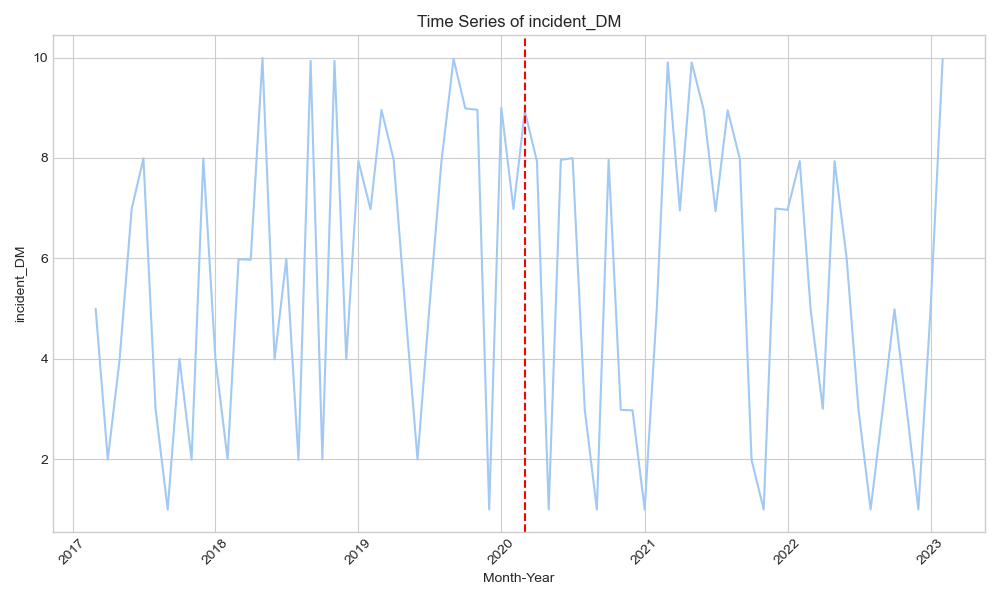

<IPython.core.display.Javascript object>


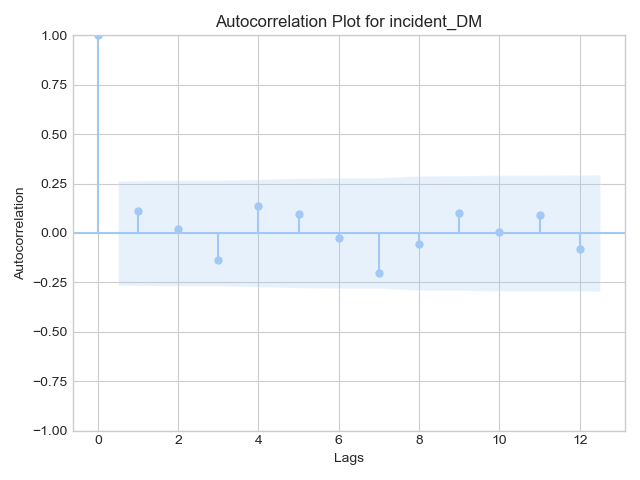

<IPython.core.display.Javascript object>


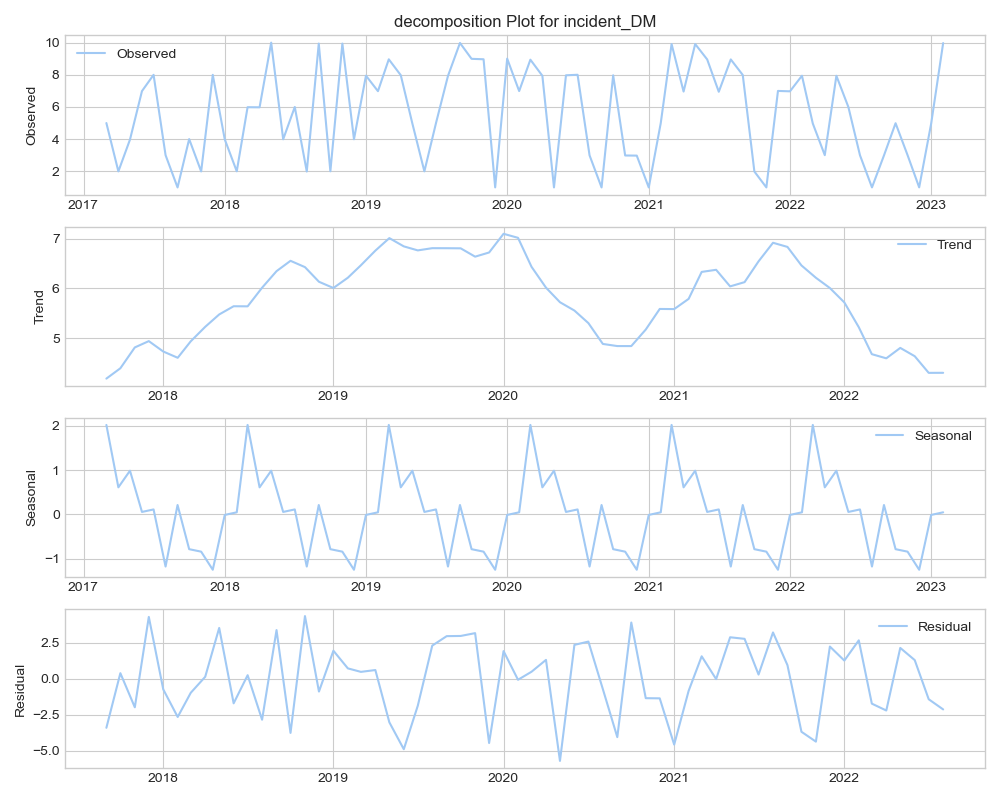

In [18]:
%matplotlib notebook

# import toolboxes
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# List of y's to iterate over (I simpily here to one item in list, but you can add more to the list)
Y = ['incident_DM']

# Iterate over each dependent variable column
for i in Y:
    y = df[i]
# step 1: plot the data to understand patterns: pre-existing trends, seasonal effects, outliers
# Set Seaborn styling
    sns.set_style('whitegrid')
    sns.set_palette('pastel')

# Create the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x='MONTH_DATE', y=f'{i}')
    plt.axvline(pd.to_datetime(date_string), color='r', linestyle='--', label='Intervention')
    plt.xlabel('Month-Year')
    plt.ylabel(f'{i}')
    plt.title(f'Time Series of {i}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create the autocorrelation plot
    plot_acf(df[f'{i}'], lags=12, alpha=0.025)  # Set the number of lags you want to display
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation Plot for {i}')
    plt.tight_layout()
    plt.show()

# Decompose the time series
    result = seasonal_decompose(df[f'{i}'], model='additive', period=12)  # Adjust the period based on your data

# Create the decomposition figure
    plt.figure(figsize=(10, 8))


    plt.subplot(411)
    plt.title(f'decomposition Plot for {i}')
    plt.plot(df['MONTH_DATE'], result.observed, label='Observed')
    plt.legend()
    plt.ylabel('Observed')

    plt.subplot(412)
    plt.plot(df['MONTH_DATE'], result.trend, label='Trend')
    plt.legend()
    plt.ylabel('Trend')

    plt.subplot(413)
    plt.plot(df['MONTH_DATE'], result.seasonal, label='Seasonal')
    plt.legend()
    plt.ylabel('Seasonal')

    plt.subplot(414)
    plt.plot(df['MONTH_DATE'], result.resid, label='Residual')
    plt.legend()
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()


## Run segmented regression model assuming normal distribution (family: Gaussian)


The level change is determined by "Intervention" variable with 0's prior to the intervention and 1's after the intervention
The slope change is determined by "intervention_time" variable, with 0's prior to the intervention and 1 to 36 after the intervention.

The level models the value of the timeseries at the beginning of a given time interval, and the trend is the rate of change of a measure (i.e. the slope) during a segment.  The analysis examines the change in level and trend which follow the intervention (covid 19).

                            OLS Regression Results                            
Dep. Variable:            incident_DM   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.778
Date:                Sat, 20 Jan 2024   Prob (F-statistic):              0.160
Time:                        18:11:08   Log-Likelihood:                -177.12
No. Observations:                  72   AIC:                             362.2
Df Residuals:                      68   BIC:                             371.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9221      0

C:\Users\Y432164\AppData\Local\Temp\ipykernel_24836\3208180599.py:81: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>


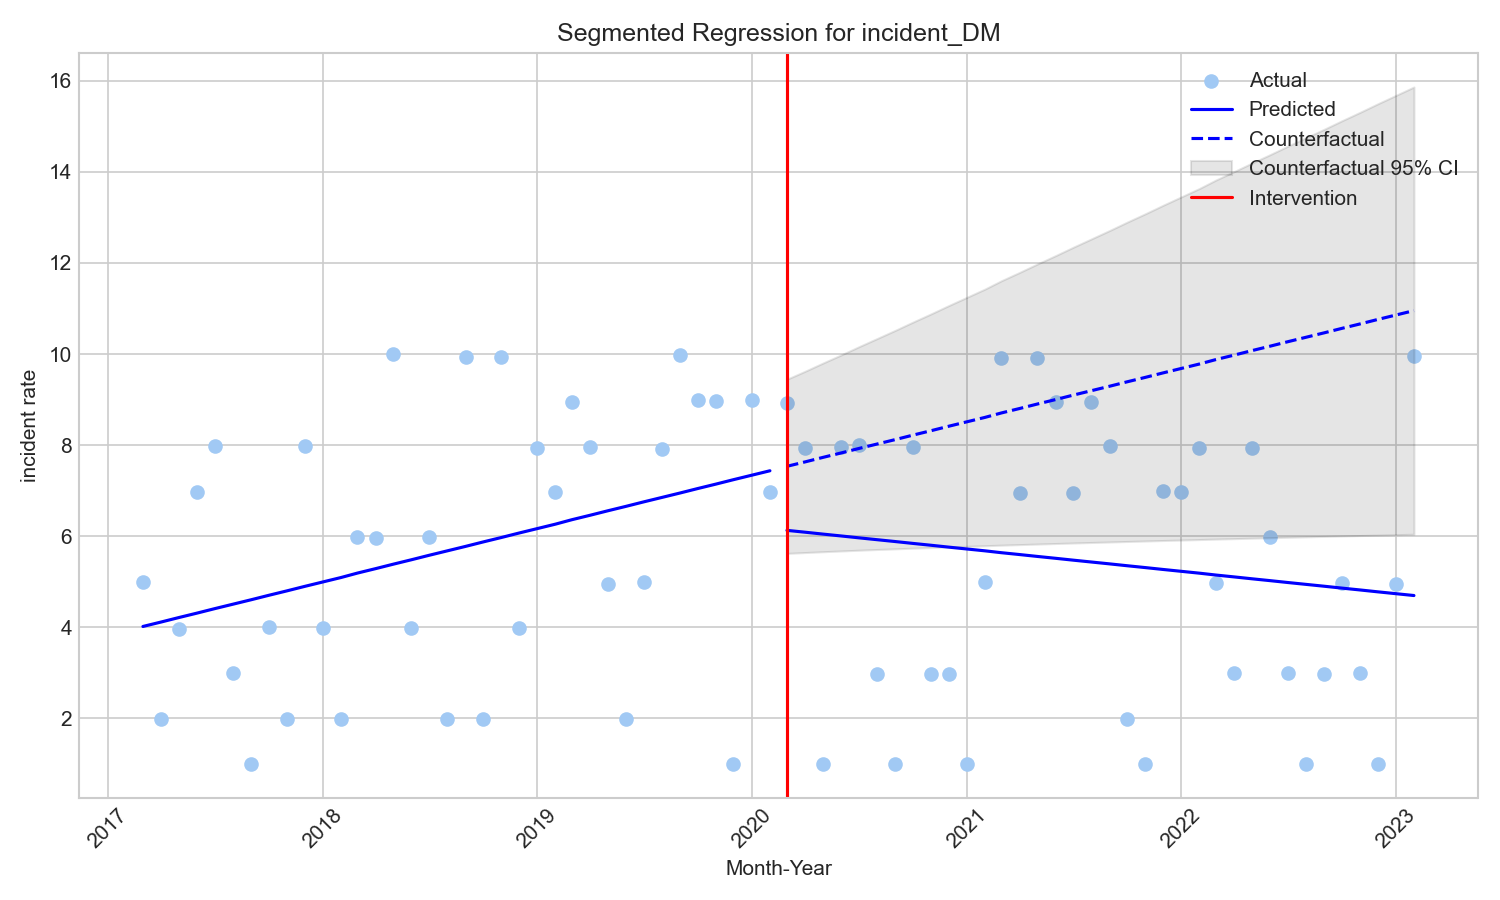

In [12]:
import statsmodels.api as sm

## OLS MODELING
# Prepare data for segmented regression
# assumption: independently distributed residuls (no autocorrelation among timepoints)

# specify start timepoint and end timepoint
start = 36
end = 72

# X and Y specifications
X = df[['Month', 'Intervention', 'Intervention_month']]

# List of y's to iterate over (list was simplified, adjust accordingly to your needs)
Y = ['incident_DM']

# Create a dictionary to store model summary DataFrames
summary_dict = {}

# Add constant to the predictor matrix to account for intercept
X = sm.add_constant(X)

# Iterate over each dependent variable column
for i in Y:
    y = df[i]
# In segmented regression, the term "segmented" indicates that the linear relationship between teh variables may differ
# across different segments of the data. This often involves fitting multiple linear equations to different parts of
# the data, each with its own set of coefficients. These segments are typically determined by breakpoints or change
# points, where the relationship between the variables changes.

# Fit the segmented regression model (Ordinary Least Squares)
    model = sm.OLS(y, X).fit()

# Print model summary
    print(model.summary())

# Print interpretation of findings:
    print('')
    print('Model interpretation:')
    print(f'Intercept (baseline) for {i} =', round(model.params[0], 2), ', meaning', round(model.params[0], 2), 'per 100,000 people have', f'{i}', 'at the beginning of the study.')
    print(f'Beta1 (time) for {i} =', round(model.params[1], 2), ', meaning the change in the mean monthly incident rate before the intervention is trending at',round(model.params[1], 2), 'per 100,000 every month')
    print(f'Beta2 (intervention) for {i} =', round(model.params[2], 2), ', meaning the level of the monthly incident rate immediately after covid differed by', round(model.params[2], 2), 'per 100,000 people')
    print(f'Beta3 (time after intervention) for {i} =', round(model.params[3], 2), ', meaning the trend in the monthly incident rate after covid compared to before covid changed by', round(model.params[3], 2), 'per 100,000 in mean monthly incident rate')

# convert model summary to a table so that it can be saved as Excel sheet later
    summary_df = model.summary2().tables[1]
    summary_dict[i] = summary_df

# Get model predictions and confidence intervals
# (1) use the get_prediction method to generate predictions and confidence intervals based on the input features (X)
    predictions = model.get_prediction(X)
# (2) get predicted mean from predictions (this is the same as model.predict(X))
    y_pred = predictions.predicted_mean
# (3) get confidence interval from predictions (same result as y_conf_int = predictions.conf_int(), but with ci labels)
    y_conf_int = predictions.summary_frame(alpha=0.05)

# create df for counterfactual (make Intervention and Intervention_month column both 0)
# the cf_y is the same as y (I just want to add that for clarity reason)
    cf_X = X.copy()
    cf_X['Intervention'] = 0
    cf_X['Intervention_month'] = 0
    cf_y = y.copy()

# fit counterfactual model (in xboard tutorial, it uses all data in df, but I really think you just need the first half)
    # cf_model = sm.OLS(cf_y, cf_X).fit()
    cf_model = sm.OLS(cf_y[:start], cf_X[:start]).fit()

# Print conterfactual model summary
    # print(cf_model.summary())

# get counterfactual model prediction of cf_y based on cf_X
# get the predicted mean & confidence interval using summary_frame (it has labels)
    # cf_predictions = cf_model.get_prediction(cf_X).summary_frame(alpha=0.05)
    cf_predictions = cf_model.get_prediction(cf_X[start:]).summary_frame(alpha=0.05)
    # cf_y_pred = cf_predictions.predicted_mean
    # cf_y_conf_int = cf_predictions.summary_frame(alpha=0.05)

# Plot the actual and predicted values for segmented regression model (use ax so that we can draw counterfactual
# on right half of the graph)
# set plot setting using subplot
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

# draw scatter plot of raw data point
    ax.scatter(df['MONTH_DATE'], y, label='Actual')

# plot predicted mean by segments (prior to intervention [:start] and after invention [start:])
    ax.plot(df['MONTH_DATE'][:start], y_pred[:start], 'b-', label='Predicted')
    ax.plot(df['MONTH_DATE'][start:], y_pred[start:], 'b-'),

# plot counterfactual mean (after intervention only) with 95% conf_int
    ax.plot(df['MONTH_DATE'][start:], cf_predictions['mean'], label='Counterfactual', color='b', linestyle='--')
    ax.fill_between(df['MONTH_DATE'][start:], cf_predictions['mean_ci_lower'], cf_predictions['mean_ci_upper'], color='k',
                alpha=0.1, label='Counterfactual 95% CI')

# plot line marking intevention month
    plt.axvline(pd.to_datetime(date_string), color='r', label='Intervention')
    plt.xlabel('Month-Year')
    plt.ylabel('incident rate')
    plt.title(f'Segmented Regression for {i}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Run ARIMA model


ARIMA model specification: 

**1.** non-stationarity (time series is stationary with constant mean, variance, covariance)

**2.** set ARIMA parameters to correct autocorrelation in timeseries.

**3.** seasonality: ARIMA can take care of seasonality by taking the seasonal difference (at lag 12 for monthly data). Note that when taking the seasonal difference for monthly data, the first 12 observations are lost.

You can set the parameters (AR, MA, seasonal, etc) manually.  There are many papers out there show you how to pick the parameters.  Otherwise, you can automatically pick the parameters using auto_arima algorithm from pmdarima toolbox.

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=372.206, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=471.370, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=399.036, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=440.039, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=416.715, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=389.477, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=376.079, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=366.763, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=364.816, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=363.683, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=364.764, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.785 seconds
                               SARIMAX Resu

C:\Users\Y432164\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Y432164\AppData\Local\Temp\ipykernel_24836\3506094229.py:61: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<IPython.core.display.Javascript object>


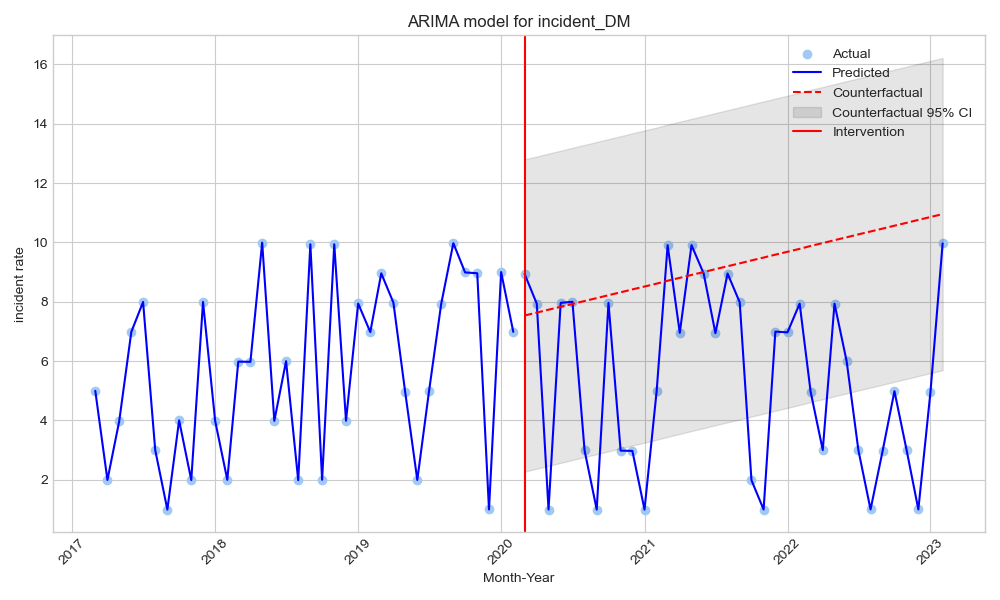

<IPython.core.display.Javascript object>


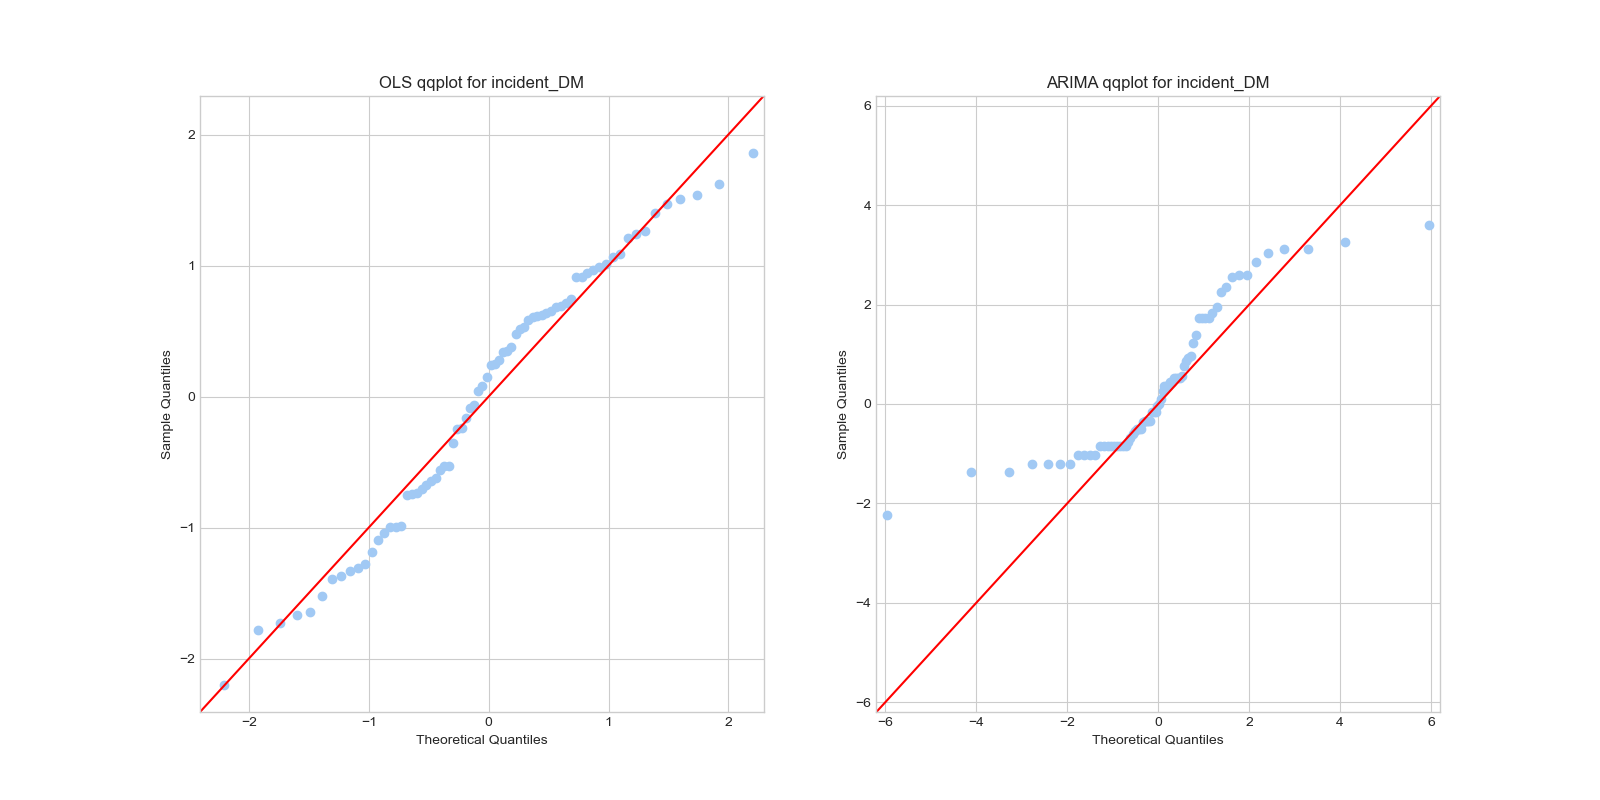

In [19]:
# import toolboxes
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.gofplots import qqplot
import scipy as sp

# X specifications
X = df[['incident_DM', 'Month', 'Intervention', 'Intervention_month']]

# List of y's to iterate over
Y = ['incident_DM']

# Iterate over each dependent variable column
for i in Y:
    y = df[i]

# use auto_arima to find best model: 
    auto_arima_model = pm.auto_arima(y, exogenous=X, seasonal=False,
                      stepwise=True, trace=True,
                      start_p=1, d=None, start_q=1,
                      max_p=3, max_d=2, max_q=3,
                      start_P=1, D=None, start_Q=1,
                      max_P=2, max_D=1, max_Q=2,
                      m=0,  # Seasonal period (12 for monthly data)
                      error_action='ignore',
                      suppress_warnings=True)
    
# Print the summary of the best model
    # print(auto_arima_model.summary())

# generate arima model using auto_arima
    arima_model = ARIMA(y, X, order=auto_arima_model.order).fit()
    print(arima_model.summary())

# replace model order if needed (manually input parameters)
    # manual_model_order = (1, 0, 0)

# get model predictions and confidence interval
# (1) use the get_prediction method to generate preditions and confidence intervals based on the input features (X)
    predictions = arima_model.get_prediction(0, end-1)
    y_pred = predictions.predicted_mean
    y_conf_int = predictions.summary_frame(alpha=0.05)

# create df for counterfactual (make Intervention and Intervention_month column both 0)
# Y = intercept + b1T + b2D + b3P + e (when D and P are both zeros, then this equation is the same as Y=b0+b1T+e)
# note that we will only include "Month" variable in the model predictor, since "Intervention" and "Intervention_month" are both 0
    cf_X = X.copy()
    cf_X['Intervention'] = 0
    cf_X['Intervention_month'] = 0
    cf_y = y.copy()

# fit counterfactual model (use data points prior to the intervention to fit the model).
    cf_model = ARIMA(cf_y[:start], cf_X['Month'][:start], order=auto_arima_model.order).fit()
    # cf_model = ARIMA(cf_y[:start], cf_X['Month'][:start], order=manual_model_order).fit()
    
# use the Time (Month) after intervention to derive y_counterfactual
# note 35 indicates the number of timepoints after intervention (since this is to draw prediction)
    cf_forecast = cf_model.get_forecast(36, exog=cf_X['Month'][start:]).summary_frame(alpha=0.05)
    
# set plot setting using subplot
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

# draw scatter plot of raw data point
    ax.scatter(df['MONTH_DATE'], y, label='Actual')

# plot predicted mean by segments (prior to intervention [:start] and after invention [start:])
    ax.plot(df['MONTH_DATE'][:start], y_pred[:start], 'b-', label='Predicted')
    ax.plot(df['MONTH_DATE'][start:], y_pred[start:], 'b-')

# plot counterfactual mean (after intervention only) with 95% conf_int
    ax.plot(df['MONTH_DATE'][start:], cf_forecast['mean'], label='Counterfactual', color='r', linestyle='--')
    ax.fill_between(df['MONTH_DATE'][start:], cf_forecast['mean_ci_lower'], cf_forecast['mean_ci_upper'],
                    color='k',
                    alpha=0.1, label='Counterfactual 95% CI')

# plot line marking intevention month
    plt.axvline(pd.to_datetime(date_string), color='r', label='Intervention')
    plt.xlabel('Month-Year')
    plt.ylabel('incident rate')
    plt.title(f'ARIMA model for {i}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plotting residuals to see if errors are randomly dispersed.  If so, then no autocorrelation.

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    sm.qqplot(model.resid, sp.stats.t, fit=True, line="45", ax=ax1);
    ax1.set_title(f"OLS qqplot for {i}")

    sm.qqplot(arima_model.resid, sp.stats.t, fit=True, line="45", ax=ax2);
    ax2.set_title(f"ARIMA qqplot for {i}")
    plt.show()


## ARIMA model result:

The auto_arima algorithm actually came back as ARIMA(0,0,0)(0,0,0).  It means fitting a constant term without any autoregressive (AR) or moving average (MA) components (i.e. without any temporal dependencies). This is equivalent to fitting a simple ordinary least squares (OLS) regression model with a constant, i.e. the predicted values from the ARIMA(0,0,0) model would be the same as the mean of the observed values.  That is why you see the counterfactual line is a straight line.

This result of ARIMA(0,0,0)(0,0,0) is expected as you can see no significant autocorrelation at a lag of 1 in Figure 2. In the model we also specified no seasonal trend. 

You will only use ARIMA model if you think there is autocorrelation in timeseries and seasonal trends.  

- The End